# Kinematics, Dynamics, Visualization + Control

In [1]:
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from sklearn.neighbors import NearestNeighbors
from functools import partial

from IPython.display import clear_output
from ocp import ILQR
from costs import *
import pdb
from utils import subsample

from scipy.optimize import fmin



np.set_printoptions(precision=4, suppress=True)
%load_ext autoreload
%autoreload 2

In [2]:
from ocp import *

In [3]:
%matplotlib inline

## Part 1: Standard Controller 

#### Try solving and analyse result

COT: 1744.10, Dist: 0.331, dT: 0.383


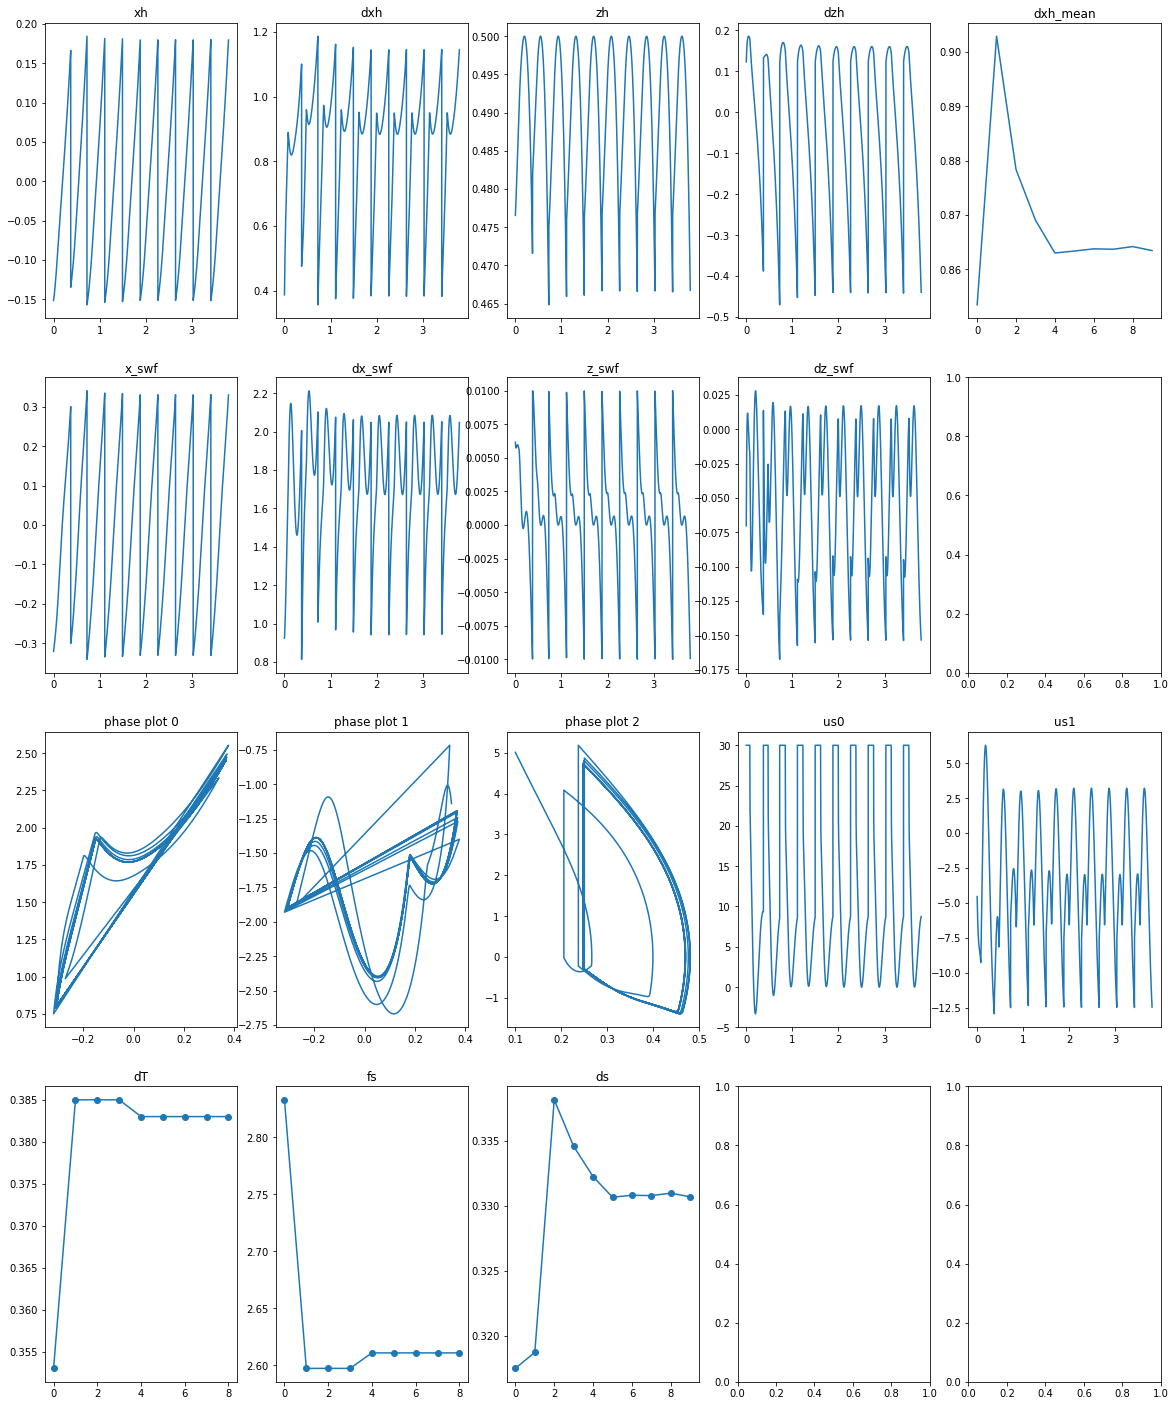

In [4]:
%matplotlib qt

biped = Biped()

#standard values with standard params
q0 = np.array([np.pi/9, -np.pi/9, 0.])
dq0 = np.array([0.,0.,8.])

#standard values with already stable limit cycle
# q0, dq0 = (np.array([-0.3035,  0.3608,  0.2487]), np.array([ 0.8319, -1.1396,  4.6439]))
# qT, dqT = (np.array([ 0.3623, -0.3046,  0.2487]), np.array([ 2.4543, -1.8658, -0.2872]))
# T = int(0.375/biped.dT)

# #standard values with already (almost) stable limit cycle for ilqr
#q0, dq0 = (np.array([-0.3075,  0.3459,  0.2666]), np.array([ 0.8131, -1.1405,  5.0078]))
q0, dq0 = (np.array([-0.3075,  0.3459,  0.1]), np.array([ 0.8131, -1.1405,  5.0078]))
qT, dqT = (np.array([ 0.3623, -0.3046,  0.2487]), np.array([ 2.4543, -1.8658, -0.2872]))
#(array([-0.3025,  0.3241,  0.233 ]), array([ 0.8955, -1.4391,  4.6021]))
#(array([-0.3038,  0.3368,  0.2396]), array([ 0.8731, -1.3125,  4.6623]))
T = int(0.375/biped.dT)

sln = biped.solve_eqns(q0, dq0, 10, biped.control_parameters)
clear_output()

#biped.animate(sln, dt = 0.001)
%matplotlib inline
res = biped.analyse(sln, biped.control_parameters, to_plot=True)

xs_std, us_std = np.hstack([res['qs'], res['dqs']]), res['us']
ddqs_std = np.array(np.gradient(xs_std, axis=0))[:,3:]/biped.dT

#### Try optimizing

In [8]:
def opt_func(opt_parameters, num_steps):
    print(num_steps)
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    x = opt_parameters[6:]

    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, x);
    results = biped.analyse(sln, x, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    effort = results['effort']
    distance = np.sum(results['ds'])
    frequency = (results['fs'][-1])
    velocity = results['total_mean_velocity']
    CoT = results['cot']
    w1, w2, vd = .1, 0.1, 1.
    objective_value = w1*abs(vd - velocity) + w2*CoT
    #objective_value = -np.mean(results['ds']) #+ 0.0001*CoT

    if distance < 0 or CoT < 0 or velocity < 0:
        objective_value = 1000        
    print(objective_value)
    print(opt_parameters)
    return objective_value

### Observe the resulting initial and final configs

## Part 2: Using iLQR

### One step motion using standard controller

In [9]:
x0 = np.concatenate([q0, dq0])
xT = np.concatenate([qT, dqT])
xs_init, us_init, z_swfs_init, dist_init = biped.compute_control_standard(x0, T, biped.control_parameters)

effort_init = np.sum(us_init[:,0]**2 + us_init[:,1]**2)/(2*T*biped.dT*30)
cot_init = effort_init / dist_init
print(effort_init, cot_init)

(4904.182712291534, 15316.032115382275)


### Formulate the iLQR problem

In [10]:
Tc = T
x_ref = xT.copy()
biped.set_init_state(x0)

#### Define cost

In [11]:
Tc = 375

In [75]:
x_ref[2] = 0.1
#standard cost on state and control
Q = np.diag([0,0,100,0,0,0])
#Q = np.diag([1,1,1,1,1,1])
Qf = np.diag([0,0,100,0,0,0])*1
#Qf = np.diag([100,100,100,100,100,100])*10
R = np.eye(biped.Du)*.01

#swing trajectory
Wt = np.diag([0, 1e4])*1
z_refs = np.linspace(0.01, -0.0, Tc)

#swing foot final position
WT = np.diag([1e3, 1e4])*1
p_ref = np.array([0.31, -0.01])

# #velocity of hip
# Wv = np.diag([1e3,1e3])*0
# v_ref = np.array([.8, 0])

costs = []
for i in range(Tc):
    if i < Tc/3:
        runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
    else:
        runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)
        
    runningControlCostShort = CostModelQuadratic(biped, None, R)
    p_ref_t = np.array([0, z_refs[i]])
    
    if i > Tc/2:
        runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
    else:
        runningEECost = CostModelQuadraticTranslation(biped, .1*Wt, p_ref = p_ref_t)
        
    runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
    costs += [runningCostShort]
    
terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(biped, None,R)
# terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost ])
costs += [terminalCost]

In [76]:
import crocoddyl

In [77]:
from ocp_sys import *

In [78]:
#### Setup crocoddyl model
rmodels = []
for i in range(Tc):
    state = crocoddyl.StateVector(biped.Dx)
    rmodel = ActionModelRobot(state, biped.Du)
    rmodel.init_robot_sys(biped, nr = biped.Dx)
    rmodel.set_cost(costs[i])
    rmodel.u_lb = np.array([-30, -30])
    rmodel.u_ub = np.array([30,30])
    rmodels += [rmodel]

rmodel_T = ActionModelRobot(state, biped.Du)
rmodel_T.init_robot_sys(biped, nr = biped.Dx)
rmodel_T.set_cost(terminalCost)
rmodel_T.u_lb = np.array([-30, -30])
rmodel_T.u_ub = np.array([30,30])


In [79]:
problem = crocoddyl.ShootingProblem(x0, rmodels, rmodel_T)

In [80]:
ddp = crocoddyl.SolverBoxFDDP(problem)

ddp.th_grad = 1e-6
ddp.th_stop = 1e-6
ddp.setCallbacks([crocoddyl.CallbackVerbose()])

ddp.solve(list(xs_init[:,:,None]), list(us_init[:-1,:,None]), maxiter=100)

xs_ref, us_ref = np.array(ddp.xs), np.array(ddp.us)

In [81]:
%matplotlib qt

biped.animate_ys(xs_ref)

array([ 0.0062,  0.0067,  0.0091,  0.0123,  0.0158,  0.0193,  0.0224,
        0.0251,  0.0272,  0.0288,  0.0297,  0.03  ,  0.0297,  0.0287,
        0.0271,  0.0249,  0.0222,  0.0191,  0.0158,  0.0124,  0.0092,
        0.0063,  0.0034,  0.0008, -0.0015, -0.0034, -0.0045, -0.0049,
       -0.0047, -0.004 , -0.0032, -0.0022, -0.0013, -0.0005, -0.0001,
       -0.0002, -0.0012, -0.0033])

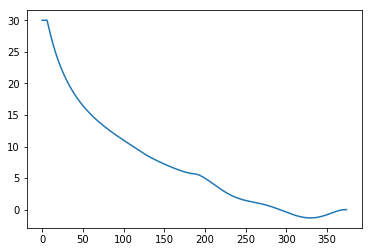

In [82]:
%matplotlib inline
plt.plot(us_ref[:,0])

#### Define iLQR

In [45]:
ilqr = ILQR(biped)
ilqr.set_init_state(x0)
ilqr.set_timestep(Tc)
ilqr.set_cost(costs)

#### Define ilqr using Crocoddyl

#### Initialization

In [46]:
init_types = ['control_std', 'inv_dyn', 'zeros']
init_type = 1
if init_type == 0:
    xs_init, us_init,_,_ = biped.compute_control_standard(x0, Tc, biped.control_parameters)
elif init_type == 1:
    xs_init = np.array([x0]*(Tc+1))
    us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((Tc+1, 3))))
    biped.set_init_state(x0)
    #xs_init = biped.rollout(us_init)
elif init_type == 2:
    us_init = np.zeros((Tc+1, biped.Du))
    biped.set_init_state(x0)
    xs_init = biped.rollout(us_init[:-1])
    
%matplotlib qt 
#biped.animate_ys(xs_init)

In [47]:
ilqr.set_state(xs_init, us_init)
ilqr.solve(10)
clear_output()
xs_ilqr, us_ilqr = ilqr.xs, ilqr.us

ddqs_ilqr = np.array(np.gradient(xs_ilqr, axis = 0))[:,3:]/biped.dT

In [16]:
x_swf, z_swf, _, _ = biped.kin_swf(xs_ilqr[-1][:3], xs_ilqr[-1][3:])
print(x_swf, z_swf)

(0.3125632300618555, -0.015237363969480222)


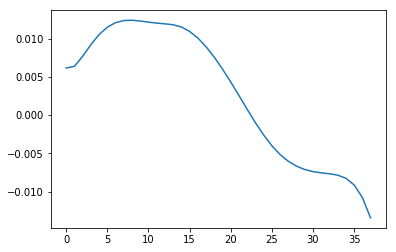

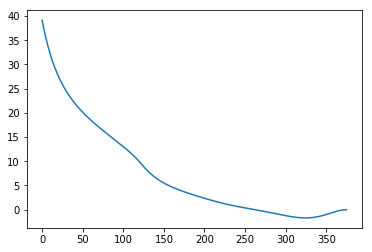

In [17]:
%matplotlib qt
z_swfs = biped.animate_ys(xs_ilqr, dt = 0.01)

%matplotlib inline
plt.plot(z_swfs)
plt.figure()
plt.plot(us_ilqr[:,0])

### Evaluate

In [23]:
effort = np.sum(us_ilqr[:,0]**2 + us_ilqr[:,1]**2)/(2*T*biped.dT*30)
print(effort)

2662.874320524204


#### Try simulation with ilqr

In [18]:
biped.set_control('ilqr', ilqr)

In [19]:
sln = biped.solve_eqns(q0, dq0,10, biped.control_parameters)
clear_output()

COT: 2195.49, Dist: 0.062, dT: 0.065


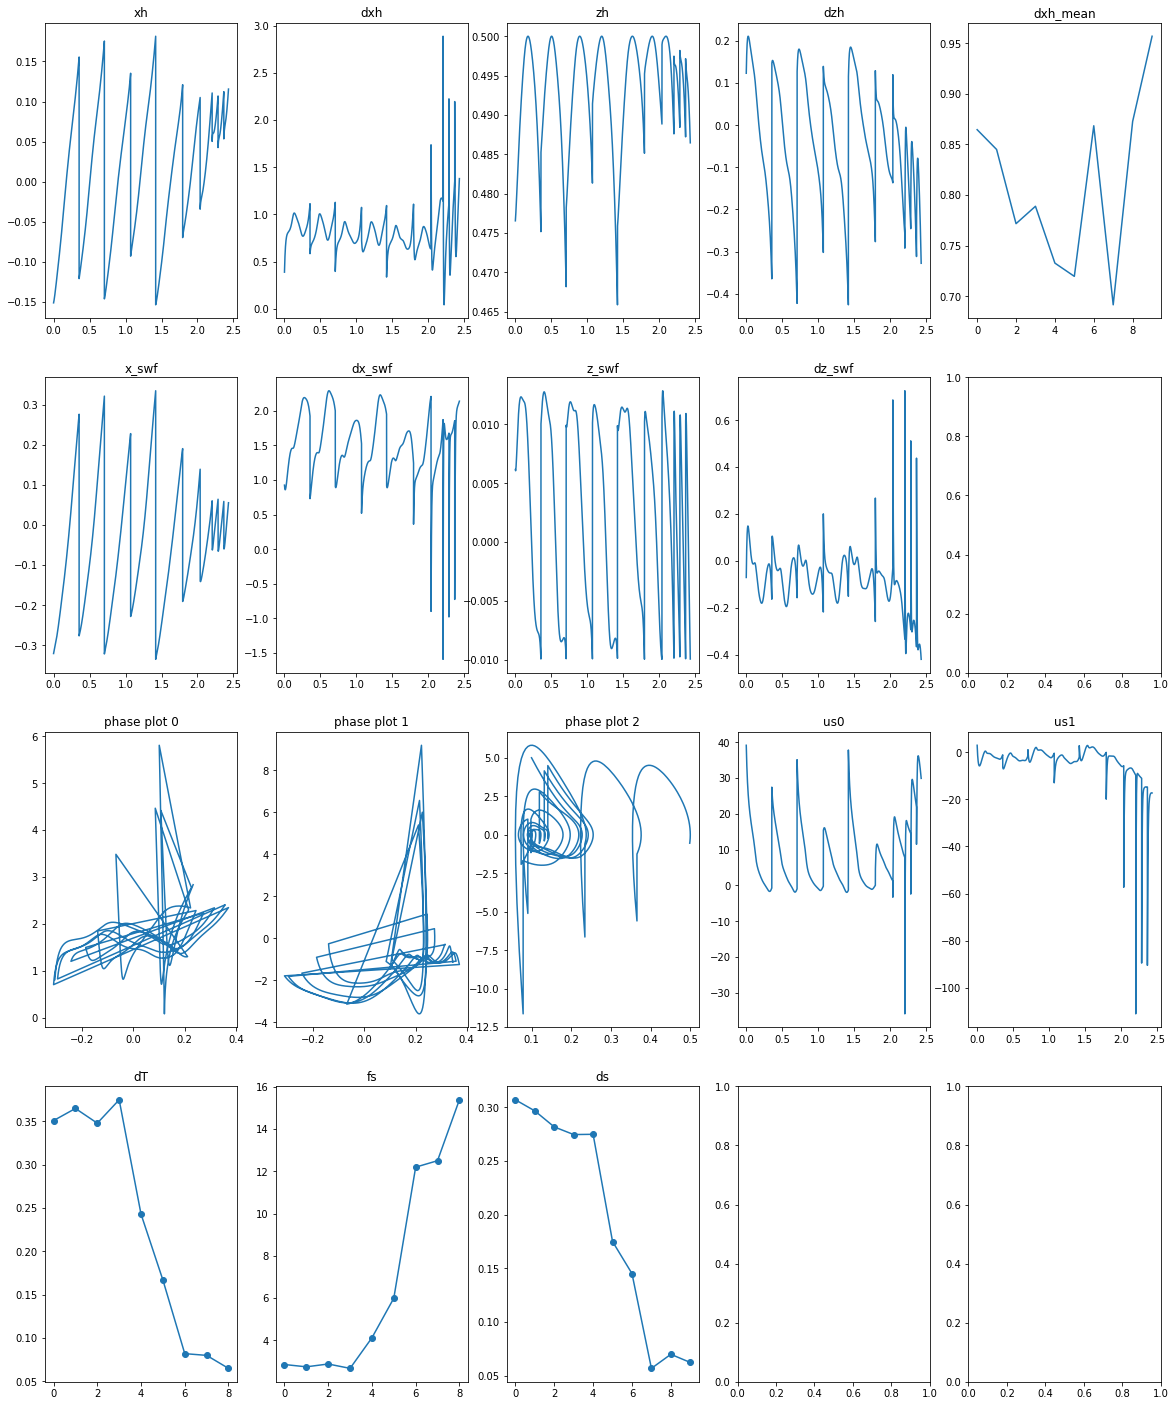

In [20]:
%matplotlib inline
_ = biped.analyse(sln, biped.control_parameters, True)

## Try optimizing

In [27]:
def opt_func_ilqr(opt_parameters, num_steps):
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
#     qT = opt_parameters[6:9]
#     dqT = opt_parameters[9:12]
    y0 = np.concatenate([q0, dq0])
#     x_ref = np.concatenate([qT, dqT])
    #Tc = opt_parameters[6]
    #alpha = 
    #step_length = 
    #
    
    #define ilqr
    ### Formulate the iLQR problem
    Tc = 375
    #x_ref = np.array([0,0,0.1,0,0,0])
    biped.set_init_state(y0.copy())

    #### Define cost
    #standard cost on state and control
    Q = np.diag([0,0,1,0,0,0])*100
    Qf = np.diag([0,0,100,0,0,0])*1
    R = np.eye(biped.Du)*.01

    #swing trajectory
    Wt = np.diag([0, 1e4])
    z_refs = np.linspace(0.01, -0.01, Tc)

    #swing foot final position
    WT = np.diag([1e3, 1e4])
    p_ref = np.array([0.31, -0.01])

    #velocity of hip
    Wv = np.diag([1e3,1e3])*0
    v_ref = np.array([.8, 0])

    costs = []
    for i in range(Tc):
        if i < Tc/3:
            runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
        else:
            runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)

        runningControlCostShort = CostModelQuadratic(biped, None, R)
        p_ref_t = np.array([0, z_refs[i]])

        if i > Tc/2:
            runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
        else:
            runningEECost = CostModelQuadraticTranslation(biped, 1*Wt, p_ref = p_ref_t)

        runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
        costs += [runningCostShort]
    terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
    terminalControlCost = CostModelQuadratic(biped, None,R)
    terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
    terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
    terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost,terminalEEVelCost ])
    costs += [terminalCost]

    #### Define iLQR

    ilqr = ILQR(biped)
    ilqr.set_init_state(y0)
    ilqr.set_timestep(Tc)
    ilqr.set_cost(costs)
    
    biped.set_control('ilqr', ilqr)
    
    #train ilqr
    biped.ilqr.set_init_state(y0.copy())
    biped.set_init_state(y0.copy())
    #params = biped.control_parameters.copy()
    #xs, us, _, _ = biped.compute_control_standard(y0, biped.ilqr.T, params)
    xs_init = np.array([y0]*(biped.ilqr.T+1))
    us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((biped.ilqr.T+1, 3))))
     
    biped.ilqr.set_state(xs_init, us_init)
    biped.ilqr.solve(5)
    clear_output()
    #biped.set_control('qp', biped.ilqr, biped.ilqr.xs)

    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, None);
    results = biped.analyse(sln, biped.control_parameters, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    max_actuation = 30;
    effort = results['effort']
    distance = np.sum(results['ds'])
    velocity = results['total_mean_velocity']
    CoT = results['cot']
    print('cot:{}'.format(CoT))
    qT = results['qs'][-1]
    dqT = results['dqs'][-1]
    
    q0n, dq0n = biped.impact(qT, dqT)
    yn = np.concatenate([q0n, dq0n])
    
    objective_value = np.linalg.norm(yn-y0)
    print('Objective: {}'.format(objective_value))
    print(y0, yn)
    return objective_value

In [31]:
#biped.set_control('ilqr', ilqr)

import time
tic = time.time()
opt_parameters0 = np.concatenate([q0, dq0])
res = fmin(opt_func_ilqr, opt_parameters0, args = (4,), disp=1, full_output=True, maxiter = 30)
clear_output()
toc = time.time()
print(toc-tic)
print(res[1])

200.653332949
0.21570678719204409


#### Simulation using Optimized parameters

COT: 2181.97, Dist: 0.062, dT: 0.065


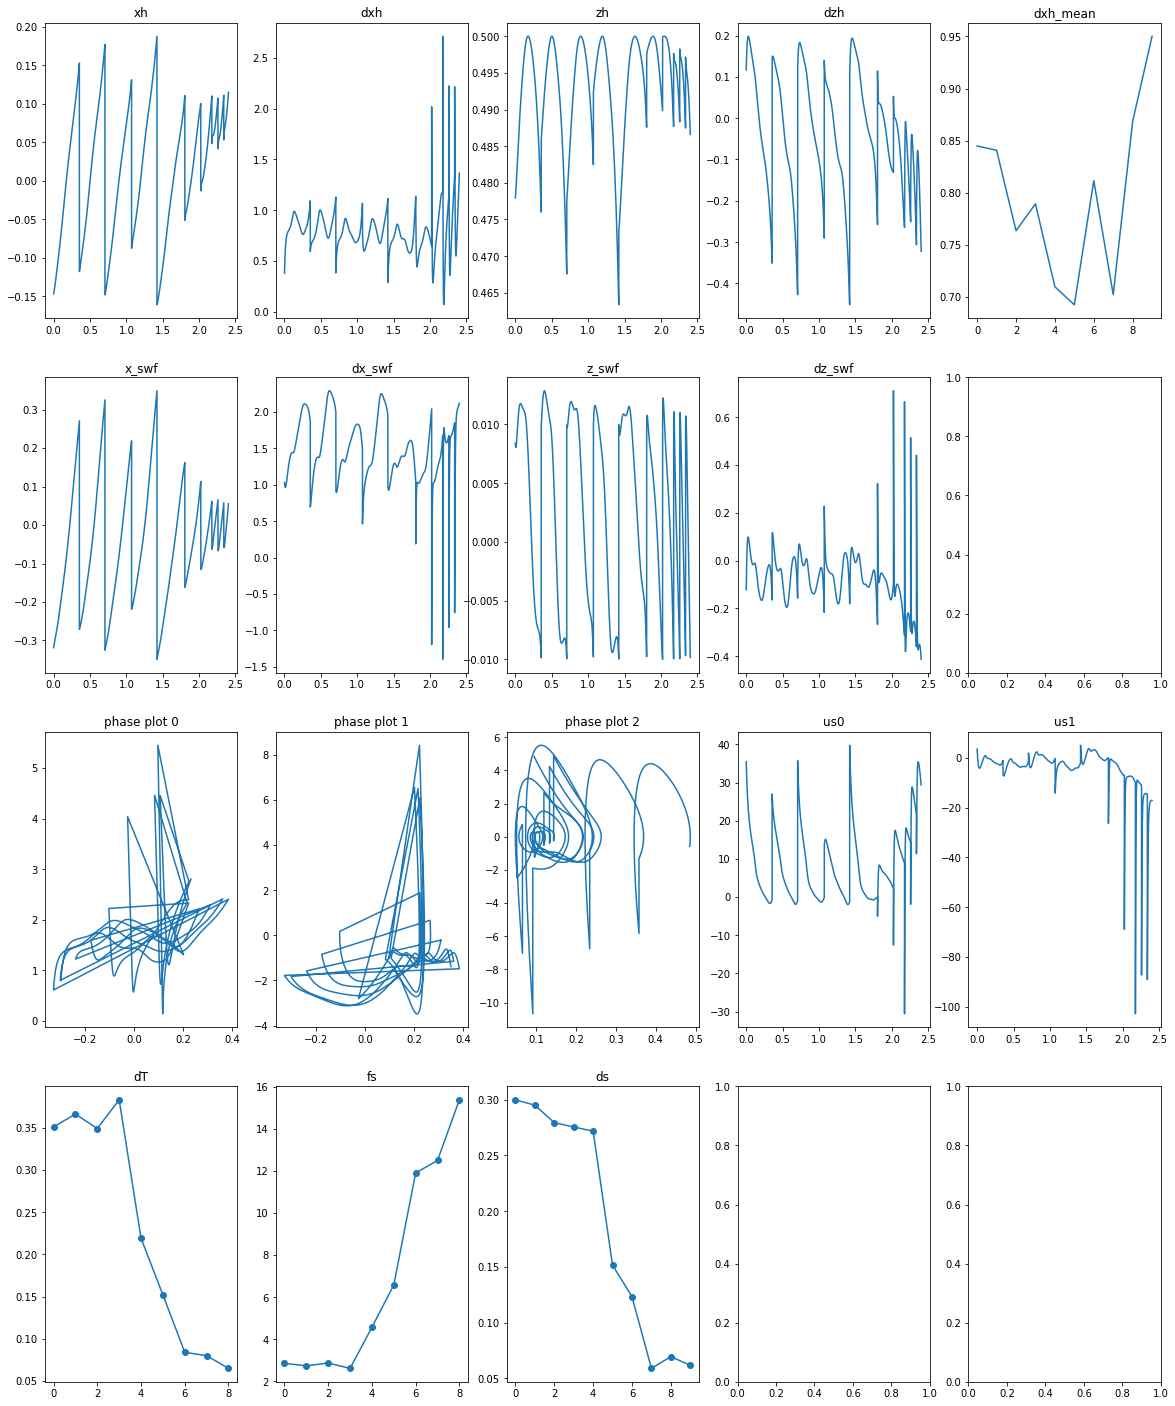

In [33]:
opt_params = res[0]
q0 = opt_params[:3]
dq0 = opt_params[3:6]
params = opt_params[6:]
params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 10, params)
%matplotlib qt
clear_output()
#biped.animate(sln)
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)

Real time factor:0.226392717271


0.2263927172706403

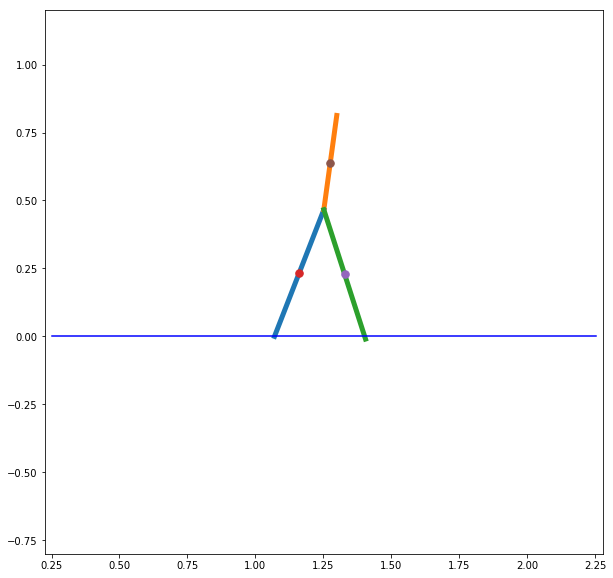

In [30]:
%matplotlib qt
biped.animate(sln)

In [301]:
biped.set_control('qp', biped.ilqr, biped.ilqr.xs, Q = 1000*np.eye(3), Kd = 200*np.eye(3), Kp = 5000*np.eye(3), max_control=60)

#### Simulation using Optimized parameters

In [302]:
opt_params = res[0]
q0 = opt_params[:3]
dq0 = opt_params[3:6]
params = opt_params[6:]
params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 10, params)
%matplotlib qt
clear_output()
biped.animate(sln)

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)
plt.savefig('d.png')

#### retrain the iLQR

#### Try simulation with ilqr

In [273]:
sln = biped.solve_eqns(q0, dq0,10, params, True)
clear_output()

biped.animate(sln)

res = biped.analyse(sln, params, False)

#### Compare against matlab